<a href="https://colab.research.google.com/github/KavyaOS/Machine_Learning/blob/main/Generative_Adversial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# LOAD DATA
(train_images, _), ( _ , _ ) = tf.keras.datasets.mnist.load_data()
# CHECK SHAPE
train_images[0].shape

11493376/11490434 [==============================] - 0s 0us/step


(28, 28)

In [4]:
# RESHAPE AND NORMALIZE IMAGES
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
# PRINT SHAPE
train_images[0].shape

(28, 28, 1)

In [5]:
# DEFINE BUFFER AND BATCH SIZE + CREATE TF DATASET
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

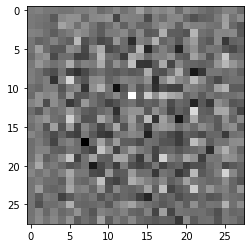

In [7]:
# TEST GENERATOR WITHOUT TRAINING
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-8.870318e-05]], shape=(1, 1), dtype=float32)


In [10]:
# DEFINE LOSS FUNCTION
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [17]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

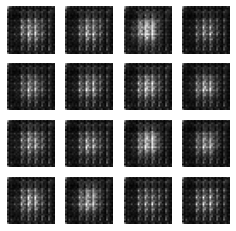

Time for epoch 1 is 15.784764766693115 sec


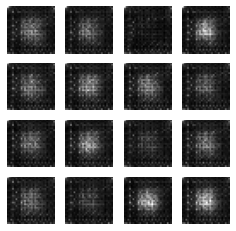

Time for epoch 2 is 13.49239444732666 sec


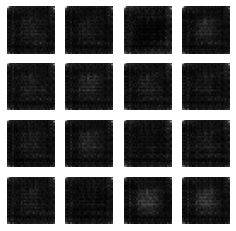

Time for epoch 3 is 13.655804872512817 sec


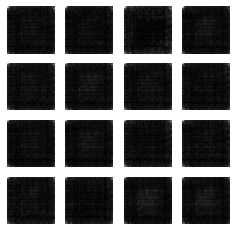

Time for epoch 4 is 13.993351221084595 sec


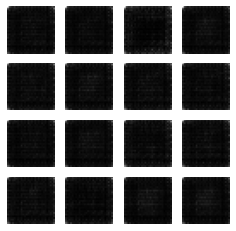

Time for epoch 5 is 13.622050523757935 sec


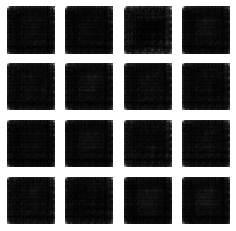

Time for epoch 6 is 13.523968696594238 sec


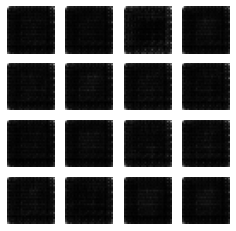

Time for epoch 7 is 13.630495548248291 sec


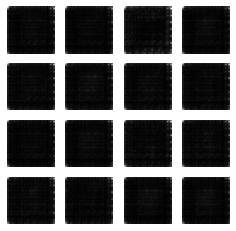

Time for epoch 8 is 13.518616676330566 sec


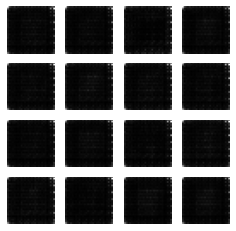

Time for epoch 9 is 13.591960668563843 sec


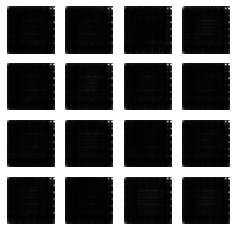

Time for epoch 10 is 13.771570444107056 sec


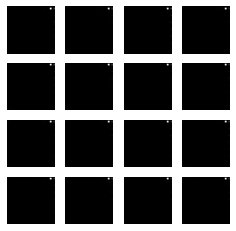

Time for epoch 11 is 13.531941413879395 sec


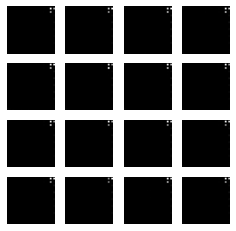

Time for epoch 12 is 13.513432741165161 sec


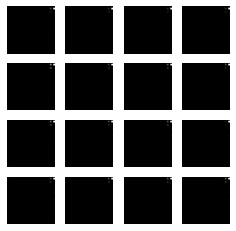

Time for epoch 13 is 13.68045449256897 sec


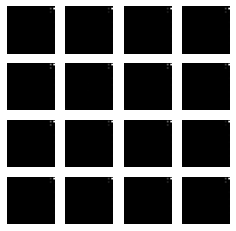

Time for epoch 14 is 13.52048635482788 sec


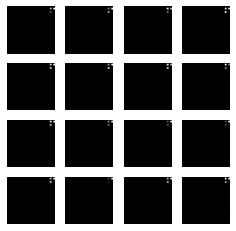

Time for epoch 15 is 13.526986837387085 sec


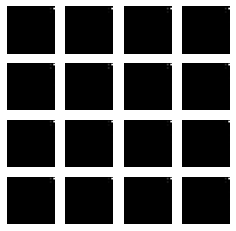

Time for epoch 16 is 13.728919506072998 sec


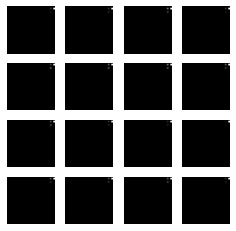

Time for epoch 17 is 13.56972336769104 sec


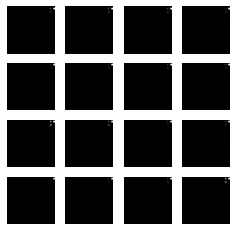

Time for epoch 18 is 13.56721830368042 sec


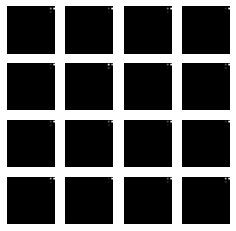

Time for epoch 19 is 13.738701820373535 sec


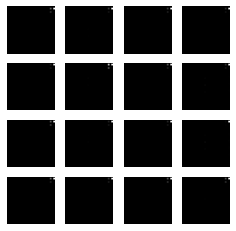

Time for epoch 20 is 13.515143632888794 sec


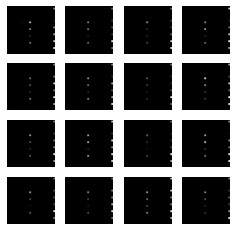

Time for epoch 21 is 13.57001543045044 sec


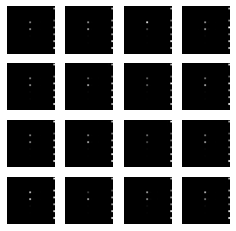

Time for epoch 22 is 13.735779762268066 sec


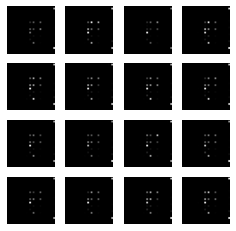

Time for epoch 23 is 13.55014181137085 sec


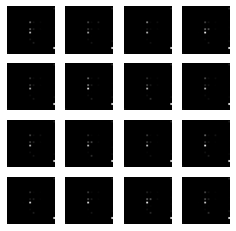

Time for epoch 24 is 13.544667959213257 sec


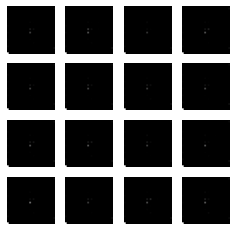

Time for epoch 25 is 13.71784496307373 sec


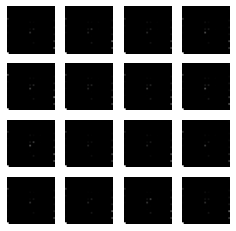

Time for epoch 26 is 13.5174720287323 sec


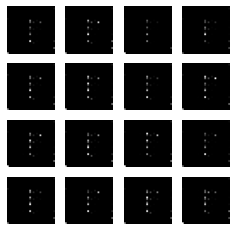

Time for epoch 27 is 13.55739951133728 sec


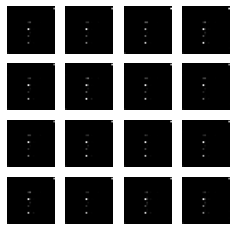

Time for epoch 28 is 13.724756479263306 sec


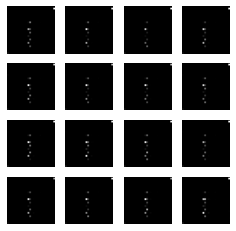

Time for epoch 29 is 13.548187494277954 sec


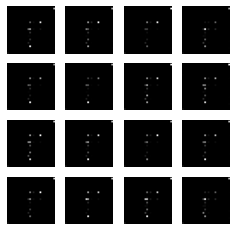

Time for epoch 30 is 13.56289529800415 sec


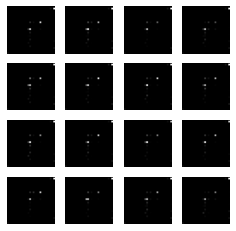

Time for epoch 31 is 13.698498964309692 sec


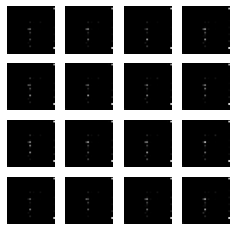

Time for epoch 32 is 13.547264337539673 sec


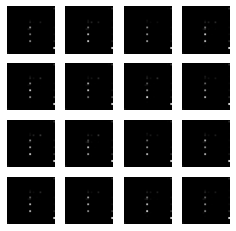

Time for epoch 33 is 13.514408588409424 sec


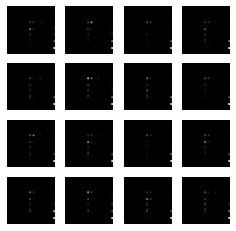

Time for epoch 34 is 13.72310495376587 sec


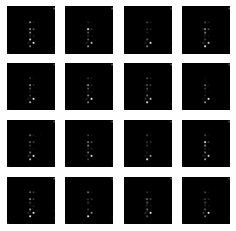

Time for epoch 35 is 13.554666519165039 sec


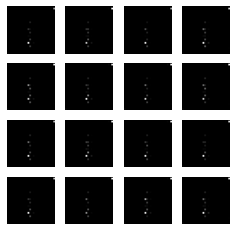

Time for epoch 36 is 13.56689453125 sec


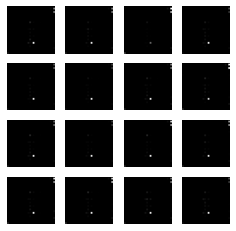

Time for epoch 37 is 13.715676546096802 sec


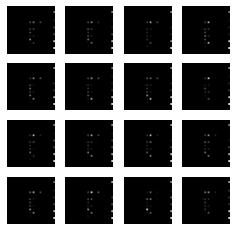

Time for epoch 38 is 13.555289506912231 sec


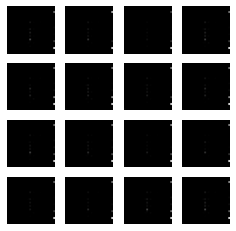

Time for epoch 39 is 13.582442045211792 sec


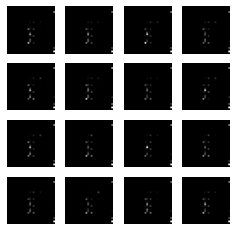

Time for epoch 40 is 13.718555450439453 sec


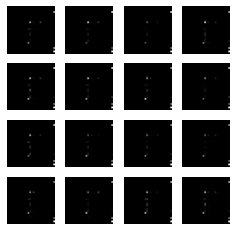

Time for epoch 41 is 13.555225849151611 sec


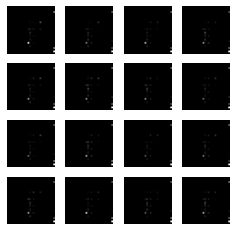

Time for epoch 42 is 13.546936273574829 sec


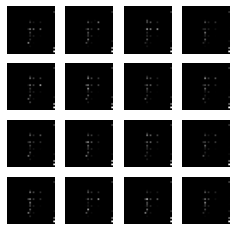

Time for epoch 43 is 13.694056987762451 sec


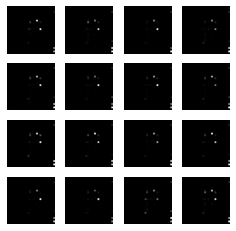

Time for epoch 44 is 13.550874710083008 sec


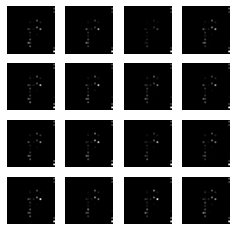

Time for epoch 45 is 13.549735069274902 sec


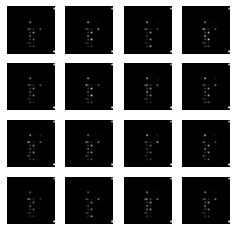

Time for epoch 46 is 13.691691637039185 sec


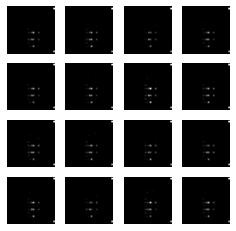

Time for epoch 47 is 13.541243314743042 sec


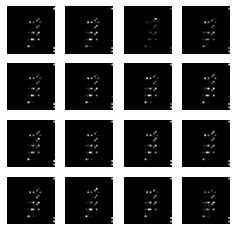

Time for epoch 48 is 13.558695793151855 sec


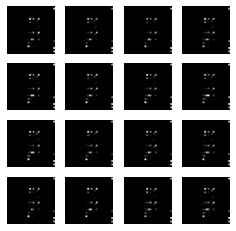

Time for epoch 49 is 13.704610109329224 sec


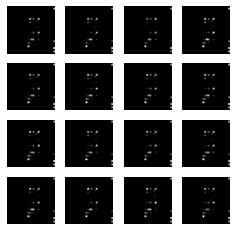

Time for epoch 50 is 13.527623653411865 sec


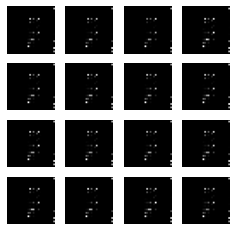

In [18]:
train(train_dataset, EPOCHS)